In [ ]:
#LIBRERIAS
libraries <- c("tidyverse",
               "readr", 
               "srvyr",
               "ggplot2",
               "showtext", 
               "modeest", 
               "foreign", 
               "haven", 
               "utils", 
               "forecast")

installed_packages <- rownames(installed.packages())
libraries_to_install <- setdiff(libraries, installed_packages)

if (length(libraries_to_install) > 0) {
  install.packages(libraries_to_install)}

lapply(libraries, library, character.only = TRUE)

In [4]:
#CONSIDERACIONES
#Tiempo de espera para la descarga
options(timeout = 8000)
#Fuente Roboto
font_add_google(name = "Roboto", family = "Roboto")
showtext_auto()
#Ajuste para la UPM
options(survey.lonely.psu = "certainty")  

**Encuesta de Ingresos y Gastos de los Hogares**

In [5]:
#Función para leer los datos de la Encuesta Nacional de Ingresos y Gastos de los Hogares (ENIGH) 
leer_enigh <- function(anio)
{ 
  #URL de descarga los datos para los años 2016, 2018, 2020 y 2022
  urls <- list("2016" = "https://www.inegi.org.mx/contenidos/programas/enigh/nc/2016/microdatos/enigh2016_ns_concentradohogar_csv.zip",
               "2018" = "https://www.inegi.org.mx/contenidos/programas/enigh/nc/2018/microdatos/enigh2018_ns_concentradohogar_csv.zip",
               "2020" = "https://www.inegi.org.mx/contenidos/programas/enigh/nc/2020/microdatos/enigh2020_ns_concentradohogar_csv.zip",
               "2022" = "https://www.inegi.org.mx/contenidos/programas/enigh/nc/2022/microdatos/enigh2022_ns_concentradohogar_csv.zip"
  )
  
  # Elementos temporales para la descarga
  temp_zip <- tempfile(fileext = ".zip")
  temp_dir <- tempdir()
  options(timeout = 800)
  
  # Descarga y descompresión del archivo ZIP
  download.file(urls[[as.character(anio)]], temp_zip, mode = "wb")
  unzip(temp_zip, exdir = temp_dir)
  
  # Selección del archivo 
  enigh_datos <- list.files(temp_dir, pattern = "concentradohogar.csv", 
                                full.names = TRUE, recursive = TRUE)
  
  # Leer el archivo como caracteres por defecto
  datos <- read_csv(enigh_datos, col_types = NULL)
  
  #Eliminar el zip y los archivos temporales
  unlink(temp_zip)
  unlink(list.files(temp_dir, full.names = TRUE), recursive = TRUE)
  
  return(datos)
}


**Porcentaje de ingreso de los hogares de menos ingresos destinado al gasto en transporte público**

In [6]:
#ENCUESTA
e2016<-leer_enigh(2016)
e2018<-leer_enigh(2018)
e2020<-leer_enigh(2020)
e2022<-leer_enigh(2022)

Rows: 70311 Columns: 127
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (6): folioviv, ubica_geo, ageb, est_dis, upm, educa_jefe
dbl (121): foliohog, tam_loc, est_socio, factor, clase_hog, sexo_jefe, edad_...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 74647 Columns: 126
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (5): folioviv, ubica_geo, est_dis, upm, educa_jefe
dbl (121): foliohog, tam_loc, est_socio, factor, clase_hog, sexo_jefe, edad_...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 89006 Columns: 126
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (5): folioviv, ubica_geo, est_dis, upm, e

In [93]:
#PORCENTAJE DE HOGARES DE LOS DECILES MÁS BAJOS, QUE EL 10% O MÁS DE SU INGRESO AL TRANSPORTE PÚBLICO
#Preparación de los datos para cada año
decil_2016 <- e2016|>
  mutate(cve_ent = substr(folioviv, 1, 2), #Obtener el código de entidad
         decil_ing = ntile(ing_cor, 10))|> #Obtener los deciles de ingreso
  filter(cve_ent == "09", 
         ing_cor > 0, 
         decil_ing <= 4)|>
  select(folioviv, foliohog, est_socio, est_dis, upm, factor, ing_cor, publico) |>
  mutate(porc_ingresos = (publico * 100) / ing_cor,
         prc_ing10 = case_when(porc_ingresos >= 10 ~ "El 10 o más", TRUE ~ "Menos del 10"),
         decil_ing = ntile(ing_cor, 10))

decil_2018 <- e2018|>
  mutate(cve_ent = substr(folioviv, 1, 2),
         decil_ing = ntile(ing_cor, 10))|>
  filter(cve_ent == "09",
         ing_cor > 0, 
         decil_ing <= 4)|>
  select(folioviv, foliohog, est_socio, est_dis, upm, factor, ing_cor, publico) |>
  mutate(porc_ingresos = (publico * 100) / ing_cor,
         prc_ing10 = case_when(porc_ingresos >= 10 ~ "El 10 o más", TRUE ~ "Menos del 10"),
         decil_ing = ntile(ing_cor, 10))


decil_2020 <- e2020|>
  mutate(cve_ent = substr(folioviv, 1, 2),
         decil_ing = ntile(ing_cor, 10))|>
  filter(cve_ent == "09",
         ing_cor > 0, 
         decil_ing <= 4)|>
  select(folioviv, foliohog, est_socio, est_dis, upm, factor, ing_cor, publico) |>
  mutate(porc_ingresos = (publico * 100) / ing_cor,
         prc_ing10 = case_when(porc_ingresos >= 10 ~ "El 10 o más", TRUE ~ "Menos del 10"),
         decil_ing = ntile(ing_cor, 10))

decil_2022 <- e2022|>
  mutate(cve_ent = substr(folioviv, 1, 2),
         decil_ing = ntile(ing_cor, 10))|>
  filter(cve_ent == "09",
         ing_cor > 0, 
         decil_ing <= 4)|>
  select(folioviv, foliohog, est_socio, est_dis, upm, factor, ing_cor, publico) |>
  mutate(porc_ingresos = (publico * 100) / ing_cor,
         prc_ing10 = case_when(porc_ingresos >= 10 ~ "El 10 o más", TRUE ~ "Menos del 10"),
         decil_ing = ntile(ing_cor, 10))


In [94]:
#Función para definir el diseño muestral
diseño_muestral <- function(anio) {
  
  objeto_datos <- get(paste0("decil_", anio))
  
  as_survey_design(objeto_datos,
                   strata = est_dis,
                   weights = factor,
                   ids = upm,
                   nest = TRUE)
}

In [95]:
dm_2016 <- diseño_muestral(2016)
dm_2018 <- diseño_muestral(2018)
dm_2020 <- diseño_muestral(2020)
dm_2022 <- diseño_muestral(2022)

In [96]:
##PORCENTAJE DE HOGARES DE DECILES MÁS BAJOS QUE DESTINAN EL 10% O MÁS
prc_ingresos_2016 <- dm_2016 |>
  group_by(prc_ing10)|>
  summarise(tot_hog_p_ingresos = survey_total(vartype = "cv"),
            porcentaje = survey_prop(vartype = "cv")*100)|>
  filter(prc_ing10 == "El 10 o más")|>
  mutate(año = 2016)

prc_ingresos_2018 <- dm_2018 |>
  group_by(prc_ing10)|>
  summarise(tot_hog_p_ingresos = survey_total(vartype = "cv"),
            porcentaje = survey_prop(vartype = "cv")*100)|>
  filter(prc_ing10 == "El 10 o más")|>
  mutate(año = 2018)

prc_ingresos_2020 <- dm_2020 |>
  group_by(prc_ing10)|>
  summarise(tot_hog_p_ingresos = survey_total(vartype = "cv"),
            porcentaje = survey_prop(vartype = "cv")*100)|>
  filter(prc_ing10 == "El 10 o más")|>
  mutate(año = 2020)

prc_ingresos_2022 <- dm_2022 |>
  group_by(prc_ing10)|>
  summarise(tot_hog_p_ingresos = survey_total(vartype = "cv"),
            porcentaje = survey_prop(vartype = "cv")*100)|>
  filter(prc_ing10 == "El 10 o más")|>
  mutate(año = 2022)

prc_gasto_tp <- prc_ingresos_2016|>
  bind_rows(prc_ingresos_2018, prc_ingresos_2020, prc_ingresos_2022)|>
  select(año,porcentaje)|>
  mutate(tipo = "Observado")

prc_gasto_tp

año,porcentaje,tipo
<dbl>,<dbl>,<chr>
2016,25.29116,Observado
2018,25.49381,Observado
2020,16.86431,Observado
2022,18.20074,Observado


In [ ]:
##ESCENARIOS TENDENCIALES 2030,2035,2045
# Método incremental
prc_gasto_tp <- prc_gasto_tp |>
  mutate(valor_lag = lag(porcentaje),
         delta = (porcentaje / valor_lag) - 1)

delta_prom <- mean(prc_gasto_tp$delta, na.rm = TRUE)

delta_prom

# Valor base 2022
valor_2022 <- prc_gasto_tp|>
  filter(año == 2022)|>
  pull(porcentaje)

# Años a proyectar
anios_proy <- c(2030, 2035, 2045)
n_periodos <- anios_proy - 2022

# Proyecciones (Inercial)
proyeccion_base <- data.frame(año = anios_proy,
                              porcentaje = valor_2022 * ((1 + 1/4*delta_prom) ^ n_periodos))|>
  mutate(tipo = "Inercial")

# Proyección deseable
delta_deseable <- 1/3*delta_prom # tasa de reducción anual

proyeccion_deseable <- data.frame(año = anios_proy,
                                  porcentaje = valor_2022 * ((1 + delta_deseable) ^ n_periodos))|>
  mutate(tipo = "Deseable")

# Proyección transformadora
delta_transformadora <- 1/2*delta_prom # tasa de reducción anual

proyeccion_transformadora <- data.frame(año = anios_proy,
                                  porcentaje = valor_2022 * ((1 + delta_transformadora) ^ n_periodos))|>
  mutate(tipo = "Transformador")

gasto_tp_hogares <- bind_rows(prc_gasto_tp,
                              proyeccion_base,
                              proyeccion_deseable, 
                              proyeccion_transformadora)

gasto_tp_hogares



[1] -0.0837452

año,porcentaje,tipo,valor_lag,delta
<dbl>,<dbl>,<chr>,<dbl>,<dbl>
2016,25.291164,Observado,NA,NA
2018,25.493811,Observado,25.29116,0.008012556
2020,16.864309,Observado,25.49381,-0.338493989
2022,18.200735,Observado,16.86431,0.079245826
2030,15.366555,Inercial,NA,NA
2035,13.823922,Inercial,NA,NA
2045,11.187698,Inercial,NA,NA
2030,14.511845,Deseable,NA,NA
2035,12.596320,Deseable,NA,NA


In [99]:
lineas <- bind_rows(data.frame(año = c(2022, 2030),
                               porcentaje = c(gasto_tp_hogares$porcentaje[gasto_tp_hogares$año == 2022 & gasto_tp_hogares$tipo == "Observado"],
                                              gasto_tp_hogares$porcentaje[gasto_tp_hogares$año == 2030 & gasto_tp_hogares$tipo == "Inercial"]),
                               tipo = "Inercial"),
                    data.frame(año = c(2022, 2030),
                               porcentaje = c(gasto_tp_hogares$porcentaje[gasto_tp_hogares$año == 2022 & gasto_tp_hogares$tipo == "Observado"], 
                                              gasto_tp_hogares$porcentaje[gasto_tp_hogares$año == 2030 & gasto_tp_hogares$tipo == "Deseable"]),
                               tipo = "Deseable"), 
                    data.frame(año = c(2022, 2030),
                               porcentaje = c(gasto_tp_hogares$porcentaje[gasto_tp_hogares$año == 2022 & gasto_tp_hogares$tipo == "Observado"], 
                                              gasto_tp_hogares$porcentaje[gasto_tp_hogares$año == 2030 & gasto_tp_hogares$tipo == "Transformador"]),
                               tipo = "Transformador"))


In [100]:
paleta_colores <- c("Observado" = "#9F2241",
                    "Inercial" = "#cfcfcf" ,
                    "Deseable" = "#027A35", 
                    "Transformador" = "#AC6D14")

linetypes <- c("Observado" = "solid",
               "Inercial" = "dotdash",
               "Deseable" = "dotdash", 
               "Transformador" = "dotdash")

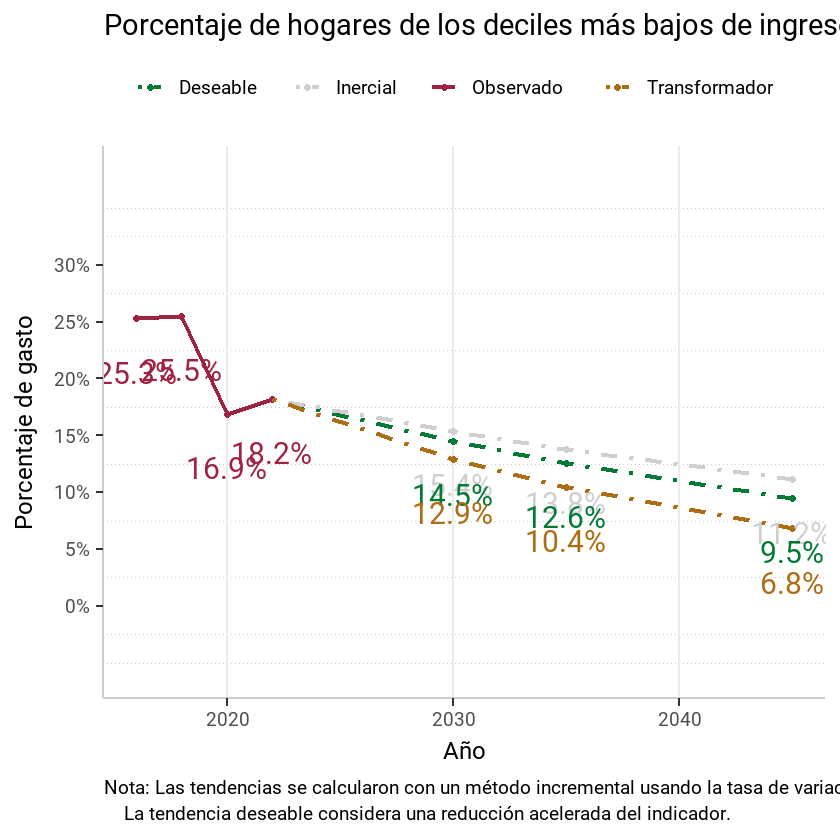

In [101]:
# Gráfico
ggplot(gasto_tp_hogares, aes(x = año, y = porcentaje, group = tipo, color = tipo, linetype = tipo)) +
  geom_line(linewidth = 1.2) +
  geom_point(size = 1.5) +
  geom_line(data = lineas, aes(x = año, y = porcentaje, group = tipo), linewidth = 1.2) +
  geom_text(aes(label = paste0(round(porcentaje, 1), "%")),
            vjust = 3, size = 8, family = "Roboto", show.legend = FALSE) +
  scale_color_manual(values = paleta_colores) +
  scale_linetype_manual(values = linetypes) +
  scale_y_continuous(
    breaks = seq(0, ceiling(max(gasto_tp_hogares$porcentaje, na.rm = TRUE) / 5) * 5, by = 5),
    labels = function(x) paste0(x, "%"),
    expand = c(0.8, 0) 
  ) +
  labs(
    title = "Porcentaje de hogares de los deciles más bajos de ingresos, que gastan el 10% o más de sus ingresos en transporte público",
    x = "Año",
    y = "Porcentaje de gasto",
    color = "",
    linetype = "",
    caption = "Nota: Las tendencias se calcularon con un método incremental usando la tasa de variación promedio anual entre los años disponibles. 
    La tendencia deseable considera una reducción acelerada del indicador."
  ) +
  theme_bw(base_size = 18, base_family = "Roboto") +
  theme(
    panel.grid.minor.y = element_line(color = "gray80", linetype = "dotted"),
    panel.grid.minor.x = element_blank(),
    panel.grid.major.y = element_blank(),
    panel.border = element_blank(),
    axis.line = element_line(color = "gray80"),
    legend.position = "top",
    plot.caption = element_text(hjust = 0)
  )

  ggsave("gasto_tp_hogares.png", width = 8, height = 5, dpi = 300)


**Porcentaje de hogares que usan transporte público como principal medio de transporte**


In [16]:
##DATOS DE GASTOS PERSONA
##Función para leer los datos de la Encuesta Nacional de Ingresos y Gastos de los Hogares (ENIGH) GASTOSPERSONA
leer_enigh <- function(anio)
{ 
  #URL de descarga los datos para los años 2018, 2020 y 2022
  urls <- list("2016" = "https://www.inegi.org.mx/contenidos/programas/enigh/nc/2016/microdatos/enigh2016_ns_gastospersona_csv.zip",
               "2018" = "https://www.inegi.org.mx/contenidos/programas/enigh/nc/2018/microdatos/enigh2018_ns_gastospersona_csv.zip",
               "2020" = "https://www.inegi.org.mx/contenidos/programas/enigh/nc/2020/microdatos/enigh2020_ns_gastospersona_csv.zip",
               "2022" = "https://www.inegi.org.mx/contenidos/programas/enigh/nc/2022/microdatos/enigh2022_ns_gastospersona_csv.zip"
  )
  
  # Archivo y directorio temporales
  temp_zip <- tempfile(fileext = ".zip")
  temp_dir <- tempdir()
  options(timeout = 800)
  
  # Descargar y descomprimir
  download.file(urls[[as.character(anio)]], temp_zip, mode = "wb")
  unzip(temp_zip, exdir = temp_dir)
  
  # Buscar el archivo de datos
  enigh_datos <- list.files(temp_dir, pattern = "gastospersona.csv", 
                            full.names = TRUE, recursive = TRUE)
  
  # Leer el archivo como caracteres por defecto
  datos <- read_csv(enigh_datos, col_types = NULL)
  
  unlink(temp_zip)
  unlink(list.files(temp_dir, full.names = TRUE), recursive = TRUE)
  
  return(datos)
}

In [17]:
#CARGAR ENCUESTA GASTOSPERSONA
gastoper2016<-leer_enigh(2016)
gastoper2018<-leer_enigh(2018)
gastoper2020<-leer_enigh(2020)
gastoper2022<-leer_enigh(2022)

Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 377013 Columns: 20
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (8): folioviv, numren, clave, tipo_gasto, mes_dia, forma_pag1, forma_pa...
dbl (11): foliohog, frec_rem, inscrip, colegia, material, cantidad, gasto, c...
lgl  (1): inst

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 398247 Columns: 20
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (8): folioviv, numren, clave, tipo_gasto, mes_dia, forma_pag1, forma_pa...
dbl (11): foliohog, frec_rem, inscrip, colegia, material, cantidad, ga

In [18]:
gastoper2016<-gastoper2016|>
  select(folioviv, foliohog, numren, clave)
gastoper2018<-gastoper2018|>
  select(folioviv, foliohog, numren, clave)
gastoper2020<-gastoper2020|>
  select(folioviv, foliohog, numren, clave)
gastoper2022<-gastoper2022|>
  select(folioviv, foliohog, numren, clave)

In [19]:
#PORCENTAJE DE HOGARES QUE USAN METRO, METROBUS O CABLEBUS Y TROLEBUS COMO PRINCIPAL MEDIO DE TRANSPORTE
# Transporte público
# B001 Metro o tren ligero
# B002 Autobús
# B003 Trolebús o metrobús
#2016
gasto_trans_pub_2016 <- gastoper2016|>
  mutate(cve_ent = substr(folioviv, 1,2))|>
  filter(cve_ent == "09")|>
  mutate(tipo_gasto = case_when(clave %in% c("B001","B002","B003") ~ "transporte publico masivo",
                                clave %in% c("B004", "B005", "B006", "B007") ~ "otros transportes publicos", 
                                clave %in% c("M001", "M002", "M003", "M004", "M005", "M006") ~ "transporte foraneo",
                                clave %in% c("M007", "M008", "M009", "M010", "M011") ~ "adquisición de vehículos", 
                                clave %in% c("M012", "M013", "M014", "M015", "M016", "M017", "M018") ~ "Refacciones para vehiculos", 
                                clave %in% c("F007", "F008", "F014") ~ "Combustibles para vehículos",
                                clave %in% c("F001", "F002", "F003", "F004", "F005", "F006","R005", "R006", "R007", "R008", "R010", "R011") ~ "comunicaciones", 
                                TRUE ~ "OTROS GASTOS"), 
         transporte = case_when(tipo_gasto == "transporte publico masivo" ~ "transporte publico masivo", 
                                tipo_gasto %in% c("transporte foraneo","otros transportes publicos","adquisición de vehículos",
                                                  "Refacciones para vehiculos","Combustibles para vehículos",
                                                  "comunicaciones") ~ "otro transporte"))|>
  filter(tipo_gasto !="OTROS GASTOS")|>
  group_by(folioviv, foliohog)|>
  summarise(tipo = mfv(transporte)[1])

gastohog_trans_pub_2016<-e2016|>
  mutate(cve_ent = substr(folioviv, 1,2))|>
  filter(cve_ent == "09")|>
  select(folioviv, foliohog, est_dis, upm, factor)|>
  left_join(gasto_trans_pub_2016, by = c("folioviv", "foliohog"))|>
  filter(!is.na(tipo))


#2018
gasto_trans_pub_2018 <- gastoper2018|>
  mutate(cve_ent = substr(folioviv, 1,2))|>
  filter(cve_ent == "09")|>
  mutate(tipo_gasto = case_when(clave %in% c("B001","B002","B003") ~ "transporte publico masivo",
                                clave %in% c("B004", "B005", "B006", "B007") ~ "otros transportes publicos", 
                                clave %in% c("M001", "M002", "M003", "M004", "M005", "M006") ~ "transporte foraneo",
                                clave %in% c("M007", "M008", "M009", "M010", "M011") ~ "adquisición de vehículos", 
                                clave %in% c("M012", "M013", "M014", "M015", "M016", "M017", "M018") ~ "Refacciones para vehiculos", 
                                clave %in% c("F007", "F008", "F014") ~ "Combustibles para vehículos",
                                clave %in% c("F001", "F002", "F003", "F004", "F005", "F006","R005", "R006", "R007", "R008", "R010", "R011") ~ "comunicaciones", 
                                TRUE ~ "OTROS GASTOS"), 
         transporte = case_when(tipo_gasto == "transporte publico masivo" ~ "transporte publico masivo", 
                                tipo_gasto %in% c("transporte foraneo","otros transportes publicos","adquisición de vehículos",
                                                  "Refacciones para vehiculos","Combustibles para vehículos",
                                                  "comunicaciones") ~ "otro transporte"))|>
  filter(tipo_gasto !="OTROS GASTOS")|>
  group_by(folioviv, foliohog)|>
  summarise(tipo = mfv(transporte)[1])


gastohog_trans_pub_2018<-e2018|>
  mutate(cve_ent = substr(folioviv, 1,2))|>
  filter(cve_ent == "09")|>
  select(folioviv, foliohog, est_dis, upm, factor)|>
  left_join(gasto_trans_pub_2018, by = c("folioviv", "foliohog"))|>
  filter(!is.na(tipo))

#2020
gasto_trans_pub_2020 <- gastoper2020|>
  mutate(cve_ent = substr(folioviv, 1,2))|>
  filter(cve_ent == "09")|>
  mutate(tipo_gasto = case_when(clave %in% c("B001","B002","B003") ~ "transporte publico masivo",
                                clave %in% c("B004", "B005", "B006", "B007") ~ "otros transportes publicos", 
                                clave %in% c("M001", "M002", "M003", "M004", "M005", "M006") ~ "transporte foraneo",
                                clave %in% c("M007", "M008", "M009", "M010", "M011") ~ "adquisición de vehículos", 
                                clave %in% c("M012", "M013", "M014", "M015", "M016", "M017", "M018") ~ "Refacciones para vehiculos", 
                                clave %in% c("F007", "F008", "F014") ~ "Combustibles para vehículos",
                                clave %in% c("F001", "F002", "F003", "F004", "F005", "F006","R005", "R006", "R007", "R008", "R010", "R011") ~ "comunicaciones", 
                                TRUE ~ "OTROS GASTOS"), 
         transporte = case_when(tipo_gasto == "transporte publico masivo" ~ "transporte publico masivo", 
                                tipo_gasto %in% c("transporte foraneo","otros transportes publicos","adquisición de vehículos",
                                                  "Refacciones para vehiculos","Combustibles para vehículos",
                                                  "comunicaciones") ~ "otro transporte"))|>
  filter(tipo_gasto !="OTROS GASTOS")|>
  group_by(folioviv, foliohog)|>
  summarise(tipo = mfv(transporte)[1])


gastohog_trans_pub_2020<-e2020|>
  mutate(cve_ent = substr(folioviv, 1,2))|>
  filter(cve_ent == "09")|>
  select(folioviv, foliohog, est_dis, upm, factor)|>
  left_join(gasto_trans_pub_2020, by = c("folioviv", "foliohog"))|>
  filter(!is.na(tipo))

#2022
gasto_trans_pub_2022 <- gastoper2022|>
  mutate(cve_ent = substr(folioviv, 1,2))|>
  filter(cve_ent == "09")|>
  mutate(tipo_gasto = case_when(clave %in% c("B001","B002","B003") ~ "transporte publico masivo",
                                clave %in% c("B004", "B005", "B006", "B007") ~ "otros transportes publicos", 
                                clave %in% c("M001", "M002", "M003", "M004", "M005", "M006") ~ "transporte foraneo",
                                clave %in% c("M007", "M008", "M009", "M010", "M011") ~ "adquisición de vehículos", 
                                clave %in% c("M012", "M013", "M014", "M015", "M016", "M017", "M018") ~ "Refacciones para vehiculos", 
                                clave %in% c("F007", "F008", "F014") ~ "Combustibles para vehículos",
                                clave %in% c("F001", "F002", "F003", "F004", "F005", "F006","R005", "R006", "R007", "R008", "R010", "R011") ~ "comunicaciones", 
                                TRUE ~ "OTROS GASTOS"), 
         transporte = case_when(tipo_gasto == "transporte publico masivo" ~ "transporte publico masivo", 
                                tipo_gasto %in% c("transporte foraneo","otros transportes publicos","adquisición de vehículos",
                                                  "Refacciones para vehiculos","Combustibles para vehículos",
                                                  "comunicaciones") ~ "otro transporte"))|>
  filter(tipo_gasto !="OTROS GASTOS")|>
  group_by(folioviv, foliohog)|>
  summarise(tipo = mfv(transporte)[1])


gastohog_trans_pub_2022<-e2022|>
  mutate(cve_ent = substr(folioviv, 1,2))|>
  filter(cve_ent == "09")|>
  select(folioviv, foliohog, est_dis, upm, factor)|>
  left_join(gasto_trans_pub_2022, by = c("folioviv", "foliohog"))|>
  filter(!is.na(tipo))


`summarise()` has grouped output by 'folioviv'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'folioviv'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'folioviv'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'folioviv'. You can override using the
`.groups` argument.


In [20]:
#Función para definir el diseño muestral
diseño_muestral <- function(anio) {
  
  objeto_datos <- get(paste0("gastohog_trans_pub_", anio))
  
  as_survey_design(objeto_datos,
                   strata = est_dis,
                   weights = factor,
                   ids = upm,
                   nest = TRUE)
}


In [21]:
dm_2016 <- diseño_muestral(2016)
dm_2018 <- diseño_muestral(2018)
dm_2020 <- diseño_muestral(2020)
dm_2022 <- diseño_muestral(2022)

In [22]:
##PORCENTAJE DE HOGARES QUE TIENEN Metro o tren ligero, Autobús, Trolebús o metrobús como principal medio de transporte
prc_hog_trans_pub_2016 <- dm_2016 |>
  group_by(tipo)|>
  summarise(tot_hog__tpublico = survey_total(vartype = "cv"),
            porcentaje = survey_prop(vartype = "cv")*100)|>
  filter(tipo == "transporte publico masivo")|>
  mutate(año = 2016)

prc_hog_trans_pub_2018 <- dm_2018 |>
  group_by(tipo)|>
  summarise(tot_hog__tpublico = survey_total(vartype = "cv"),
            porcentaje = survey_prop(vartype = "cv")*100)|>
  filter(tipo == "transporte publico masivo")|>
  mutate(año = 2018)

prc_hog_trans_pub_2020 <- dm_2020 |>
  group_by(tipo)|>
  summarise(tot_hog__tpublico = survey_total(vartype = "cv"),
            porcentaje = survey_prop(vartype = "cv")*100)|>
  filter(tipo == "transporte publico masivo")|>
  mutate(año = 2020)

prc_hog_trans_pub_2022 <- dm_2022 |>
  group_by(tipo)|>
  summarise(tot_hog__tpublico = survey_total(vartype = "cv"),
            porcentaje = survey_prop(vartype = "cv")*100)|>
  filter(tipo == "transporte publico masivo")|>
  mutate(año = 2022)


prc_hog_tp<-prc_hog_trans_pub_2016|>
  bind_rows(prc_hog_trans_pub_2018, prc_hog_trans_pub_2020, prc_hog_trans_pub_2022)|>
  select(año,porcentaje)|>
  mutate(tipo = "Observado")

prc_hog_tp

año,porcentaje,tipo
<dbl>,<dbl>,<chr>
2016,26.57430,Observado
2018,29.46108,Observado
2020,27.58408,Observado
2022,31.50581,Observado


In [23]:
#ESCENARIOS TENDENCIALES 2030,2035,2045
tcma<-((prc_hog_tp$porcentaje[prc_hog_tp$año==2022]/prc_hog_tp$porcentaje[prc_hog_tp$año==2016])^(1/(2022-2016))-1)
tcma

[1] 0.02877755

In [24]:
porcentaje_base <- prc_hog_tp |>
  filter(año == 2022) |>
  pull(porcentaje)

In [25]:
# Años a proyectar
años <- c(2030, 2040, 2045)
año_base <- 2022

In [42]:
tendencia_base <- data.frame(año = años,
                             porcentaje = round(porcentaje_base * (1 + tcma ) ^ (años - año_base), 2),
                             tipo = "Inercial")

tendecia_deseable<-data.frame(año = años,
                              porcentaje = round(porcentaje_base * (1 + tcma* 1.1 ) ^ (años - año_base), 2),
                              tipo = "Deseable")

tendecia_transformadora<-data.frame(año = años,
                              porcentaje = round(porcentaje_base * (1 + tcma* 1.2 ) ^ (años - año_base), 2),
                              tipo = "Transformador")


In [43]:
prc_hog_tp_tendencias <- prc_hog_tp|>
  bind_rows(tendencia_base,
            tendecia_deseable,
            tendecia_transformadora)

prc_hog_tp_tendencias


año,porcentaje,tipo
<dbl>,<dbl>,<chr>
2016,26.57430,Observado
2018,29.46108,Observado
2020,27.58408,Observado
2022,31.50581,Observado
2030,39.53000,Inercial
2040,52.50000,Inercial
2045,60.50000,Inercial
2030,40.43000,Deseable
2040,55.21000,Deseable


In [44]:
#PREPARACIÓN DE DATOS PARA GRAFICAR
lineas <- bind_rows(data.frame(año = c(2022, 2030),
                               porcentaje = c(prc_hog_tp_tendencias$porcentaje[prc_hog_tp_tendencias$año == 2022 & prc_hog_tp_tendencias$tipo == "Observado"],
                                              prc_hog_tp_tendencias$porcentaje[prc_hog_tp_tendencias$año == 2030 & prc_hog_tp_tendencias$tipo == "Inercial"]),
                               tipo = "Inercial"),
                    data.frame(año = c(2022, 2030),
                               porcentaje = c(prc_hog_tp_tendencias$porcentaje[prc_hog_tp_tendencias$año == 2022 & prc_hog_tp_tendencias$tipo == "Observado"], 
                                              prc_hog_tp_tendencias$porcentaje[prc_hog_tp_tendencias$año == 2030 & prc_hog_tp_tendencias$tipo == "Deseable"]),
                               tipo = "Deseable"), 
                    data.frame(año = c(2022, 2030),
                               porcentaje = c(prc_hog_tp_tendencias$porcentaje[prc_hog_tp_tendencias$año == 2022 & prc_hog_tp_tendencias$tipo == "Observado"], 
                                              prc_hog_tp_tendencias$porcentaje[prc_hog_tp_tendencias$año == 2030 & prc_hog_tp_tendencias$tipo == "Transformador"]),
                               tipo = "Transformador"))


paleta_colores <- c("Observado" = "#9F2241",
                    "Inercial" = "#cfcfcf" ,
                    "Deseable" = "#027A35", 
                    "Transformador" = "#AC6D14")

linetypes <- c("Observado" = "solid",
               "Inercial" = "dotdash",
               "Deseable" = "dotdash", 
               "Transformador" = "dotdash")

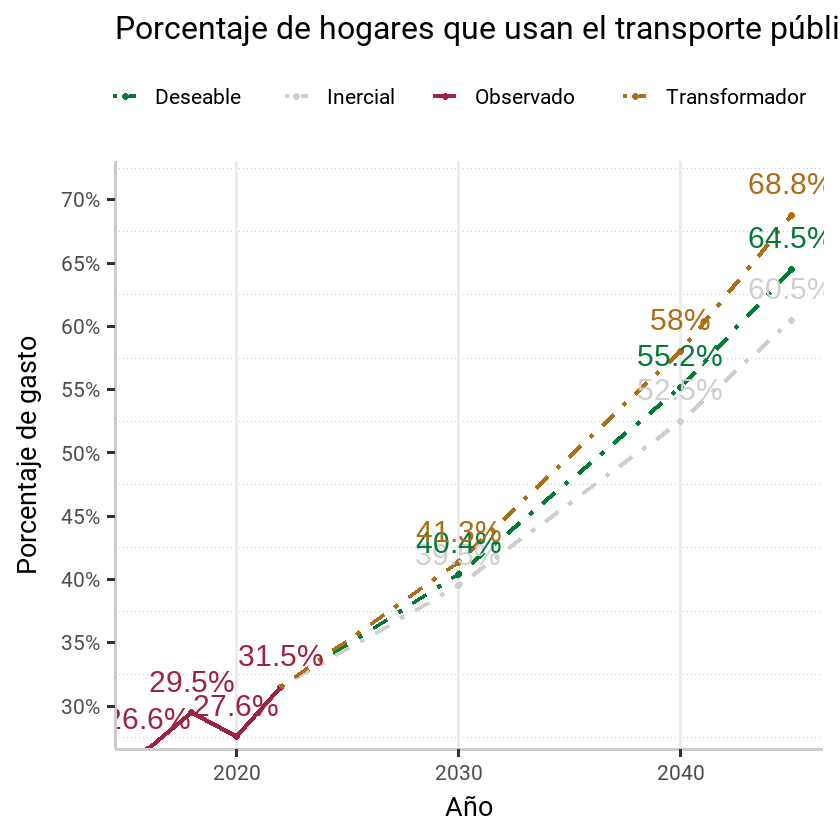

In [51]:
# Gráfico con etiquetas y eje Y personalizado
ggplot(prc_hog_tp_tendencias, aes(x = año, y = porcentaje, group = tipo, color = tipo, linetype = tipo)) +
  geom_line(linewidth = 1.2) +
  geom_point(size = 1.5) +
  geom_line(data = lineas, aes(x = año, y = porcentaje, group = tipo), linewidth = 1.2) +
  geom_text(aes(label = paste0(round(porcentaje, 1), "%")),
            vjust = -1, size = 8, show.legend = FALSE) +
  scale_color_manual(values = paleta_colores) +
  scale_linetype_manual(values = linetypes) +
  scale_y_continuous(breaks = seq(0, max(prc_hog_tp_tendencias$porcentaje, na.rm = TRUE) + 5, by = 5),
                     labels = function(x) paste0(x, "%"),
                     expand = expansion(mult = c(0, 0.1))) +
  labs(title = "Porcentaje de hogares que usan el transporte público* como principal medio de transporte",
       x = "Año",
       y = "Porcentaje de gasto",
       color = "",
       linetype = ""
      # caption = "*Se consideraron:Metro, tren ligero, Autobús, Trolebús y metrobús.
     #   Se considera la tasa de crecimiento media anual (TCMA) observada entre 2016 y 2022.
     #   La línea de tendencia deseable representa un escenario hipotético de mejora"
  ) +
  theme_bw(base_size = 20, base_family = "Roboto") +
  theme( panel.grid.minor.y = element_line(color = "gray80", linetype = "dotted"),
         panel.grid.minor.x = element_blank(),
         panel.grid.major.y = element_blank(),
         panel.border = element_blank(),
         axis.line = element_line(color = "gray80"),
         legend.position = "top",
         plot.caption = element_text(hjust = 0))

ggsave("prc_hog_tp_tendencias.png", width = 8, height = 5, dpi = 300)

**Cuestionario ampliado del censo de poblacón y vivienda y encuesta intercensal**

In [ ]:
leer_censo <- function(anio) {
  urls <- list(
    "2015_09" = "https://www.inegi.org.mx/contenidos/programas/intercensal/2015/microdatos/eic2015_09_dta.zip",
    "2020_09" = "https://www.inegi.org.mx/contenidos/programas/ccpv/2020/microdatos/Censo2020_CA_cdmx_dta.zip".
    "2015_15" = ,
    "2020_15" = ,
    "2015_13" = ,
    "2020_13" = 
  )
  
  temp_zip <- tempfile(fileext = ".zip")
  temp_dir <- tempdir()
  options(timeout = 800)
  
  download.file(urls[[as.character(anio)]], temp_zip, mode = "wb")
  unzip(temp_zip, exdir = temp_dir)
  
  archivos_dta <- list.files(temp_dir, pattern = "\\.dta$", full.names = TRUE, recursive = TRUE)
  archivo_personas <- archivos_dta[grepl("per|pers|persona|personas", archivos_dta, ignore.case = TRUE)][1]

  datos <- read_dta(archivo_personas)
  
  unlink(temp_zip)
  unlink(list.files(temp_dir, full.names = TRUE), recursive = TRUE)
  
  return(datos)
}

In [53]:
personas2015<-leer_censo(2015)
personas2020<-leer_censo(2020)

In [102]:
#listado de alcaldias de la cdmx
mun_cdmx <- data.frame(CVE_MUN = c("002", "003", "004", "005", "006", "007", "008", "009", 
              "010", "011", "012", "013", "014", "015", "016", "017"), 
              NOMGEO = c("Azcapotzalco", "Coyoacán", "Cuajimalpa de Morelos", "Gustavo A. Madero", 
             "Iztacalco", "Iztapalapa", "La Magdalena Contreras", "Milpa Alta", 
             "Álvaro Obregón", "Tláhuac", "Tlalpan", "Xochimilco", "Benito Juárez", 
             "Cuauhtémoc", "Miguel Hidalgo", "Venustiano Carranza"))|>
  mutate(cvegeo = paste0("09", CVE_MUN))

**Porcentaje de población con tiempos de traslado al trabajo o a la escuela de más de una hora**

In [106]:
#TIEMPOS DE TRASLADO AL TRABAJO O A LA ESCUELA DE MÁS DE UNA HORA
#2015
personas2015_t <- personas2015|>
  select(ent, mun, factor, upm, estrato, asisten, conact, ent_pais_asi, mun_asi, ent_pais_trab, mun_trab, tie_traslado_escu, tie_traslado_trab)|>
  mutate(mun_orig = ifelse(!is.na(mun) & nchar(mun) < 3,
                           paste0(strrep("0", 3 - nchar(mun)), mun), mun),
         mun_trab = ifelse(!is.na(mun_trab) & nchar(mun_trab) < 3,
                           paste0(strrep("0", 3 - nchar(mun_trab)), mun_trab), mun_trab),
         mun_asi = ifelse(!is.na(mun_asi) & nchar(mun_asi) < 3,
                          paste0(strrep("0", 3 - nchar(mun_asi)), mun_asi), mun_asi),
         ent_pais_trab = ifelse(!is.na(ent_pais_trab), substr(ent_pais_trab, 2, 3), na),
         ent_pais_asi = ifelse(!is.na(ent_pais_asi), substr(ent_pais_asi, 2, 3), na),
         mun_t_cvegeo = ifelse(!is.na(ent_pais_trab) & !is.na(mun_trab),
                               paste0(ent_pais_trab, mun_trab), na),
         mun_a_cvegeo = ifelse(!is.na(ent_pais_asi) & !is.na(mun_asi),
                               paste0(ent_pais_asi, mun_asi), na),
         cvegeo = paste0(ent, mun_orig),
         mun_destinos = case_when(is.na(mun_a_cvegeo) | mun_a_cvegeo == "000"~ mun_t_cvegeo,
                                  is.na(mun_t_cvegeo) | mun_t_cvegeo == "000" ~ mun_a_cvegeo,
                                  tie_traslado_trab == 1 ~ mun_a_cvegeo,
                                  tie_traslado_escu == 1 ~ mun_t_cvegeo), 
         mun_destinos = case_when(mun_destinos == "000" ~ "sin información", 
                                  TRUE ~ mun_destinos))

tiempos_traslado_2015<- personas2015_t|>
  filter(mun_destinos %in% mun_cdmx$cvegeo)|>
  mutate(tipo = case_when(tie_traslado_trab %in% c("4", "5") ~ "más tiempo", 
                          tie_traslado_escu %in% c("4", "5") ~ "más tiempo", 
                          TRUE ~ "menos tiempo"))  

#2020
personas2020_t <- personas2020|>
  select(ent, mun, factor, upm, estrato, asisten, conact, ent_pais_asi, mun_asi, ent_pais_trab, mun_trab, tie_traslado_escu, tie_traslado_trab)|>
  mutate(mun_orig = ifelse(!is.na(mun) & nchar(mun) < 3,
                           paste0(strrep("0", 3 - nchar(mun)), mun), mun),
         mun_trab = ifelse(!is.na(mun_trab) & nchar(mun_trab) < 3,
                           paste0(strrep("0", 3 - nchar(mun_trab)), mun_trab), mun_trab),
         mun_asi = ifelse(!is.na(mun_asi) & nchar(mun_asi) < 3,
                          paste0(strrep("0", 3 - nchar(mun_asi)), mun_asi), mun_asi),
         ent_pais_trab = ifelse(!is.na(ent_pais_trab), substr(ent_pais_trab, 2, 3), na),
         ent_pais_asi = ifelse(!is.na(ent_pais_asi), substr(ent_pais_asi, 2, 3), na),
         mun_t_cvegeo = ifelse(!is.na(ent_pais_trab) & !is.na(mun_trab),
                               paste0(ent_pais_trab, mun_trab), na),
         mun_a_cvegeo = ifelse(!is.na(ent_pais_asi) & !is.na(mun_asi),
                               paste0(ent_pais_asi, mun_asi), na),
         cvegeo = paste0(ent, mun_orig),
         mun_destinos = case_when(is.na(mun_a_cvegeo) | mun_a_cvegeo == "000"~ mun_t_cvegeo,
                                  is.na(mun_t_cvegeo) | mun_t_cvegeo == "000" ~ mun_a_cvegeo,
                                  tie_traslado_trab == 1 ~ mun_a_cvegeo,
                                  tie_traslado_escu == 1 ~ mun_t_cvegeo), 
         mun_destinos = case_when(mun_destinos == "000" ~ "sin información", 
                                  TRUE ~ mun_destinos))

tiempos_traslado_2020<- personas2020_t|>
  filter(mun_destinos %in% mun_cdmx$cvegeo)|>
  mutate(tipo = case_when(tie_traslado_trab %in% c("4", "5") ~ "más tiempo", 
                          tie_traslado_escu %in% c("4", "5") ~ "más tiempo", 
                          TRUE ~ "menos tiempo"))  



tiempos_traslado<-tiempos_traslado_2015|>
  bind_rows(tiempos_traslado_2020)

In [ ]:
# #TIEMPOS DE TRASLADO AL TRABAJO DE MÁS DE UNA HORA
# #2015
# personas2015_t <- personas2015|>
#   select(ent, mun, factor, upm, estrato, asisten, conact, ent_pais_trab, mun_trab, tie_traslado_trab)|>
#   mutate(mun_orig = ifelse(!is.na(mun) & nchar(mun) < 3, paste0(strrep("0", 3 - nchar(mun)), mun), mun),
#          mun_trab = ifelse(!is.na(mun_trab) & nchar(mun_trab) < 3, paste0(strrep("0", 3 - nchar(mun_trab)), mun_trab), mun_trab),
#          ent_pais_trab = ifelse(!is.na(ent_pais_trab), substr(ent_pais_trab, 2, 3), NA),
#          mun_t_cvegeo = ifelse(!is.na(ent_pais_trab) & !is.na(mun_trab), paste0(ent_pais_trab, mun_trab), NA),
#          cvegeo = paste0(ent, mun_orig),
#          mun_destinos = case_when(mun_t_cvegeo == "000" ~ "sin información", 
#                                   TRUE ~ mun_t_cvegeo))


# tiempos_traslado_2015<- personas2015_t|>
#   filter(mun_destinos %in% mun_cdmx$cvegeo)|>
#   mutate(tipo = case_when(tie_traslado_trab %in% c("4", "5") ~ "más tiempo",
#                           TRUE ~ "menos tiempo"))  

# #2020
# personas2020_t <- personas2020|>
#   select(ent, mun, factor, upm, estrato, asisten, conact, ent_pais_trab, mun_trab, tie_traslado_trab)|>
#   mutate(mun_orig = ifelse(!is.na(mun) & nchar(mun) < 3, paste0(strrep("0", 3 - nchar(mun)), mun), mun),
#          mun_trab = ifelse(!is.na(mun_trab) & nchar(mun_trab) < 3, paste0(strrep("0", 3 - nchar(mun_trab)), mun_trab), mun_trab),
#          ent_pais_trab = ifelse(!is.na(ent_pais_trab), substr(ent_pais_trab, 2, 3), NA),
#          mun_t_cvegeo = ifelse(!is.na(ent_pais_trab) & !is.na(mun_trab), paste0(ent_pais_trab, mun_trab), NA),
#          cvegeo = paste0(ent, mun_orig),
#          mun_destinos = case_when(mun_t_cvegeo == "000" ~ "sin información", 
#                                   TRUE ~ mun_t_cvegeo))



# tiempos_traslado_2020<- personas2020_t|>
#   filter(mun_destinos %in% mun_cdmx$cvegeo)|>
#   mutate(tipo = case_when(tie_traslado_trab %in% c("4", "5") ~ "más tiempo",
#                           TRUE ~ "menos tiempo"))   



# tiempos_traslado<-tiempos_traslado_2015|>
#   bind_rows(tiempos_traslado_2020)



In [108]:
#Función para definir el diseño muestral
diseño_muestral <- function(anio) {
  
  objeto_datos <- get(paste0("tiempos_traslado_", anio))
  
  as_survey_design(objeto_datos,
                   strata = estrato,
                   weights = factor,
                   ids = upm,
                   nest = TRUE)
}


In [109]:
dm_2015 <- diseño_muestral(2015)
dm_2020 <- diseño_muestral(2020)

In [110]:
tot_tie_traslado_2015 <- dm_2015 |>
  group_by(tipo)|>
  summarise(tot_personas = survey_total(vartype = "cv"),
            porcentaje = survey_prop(vartype = "cv")*100)|>
  filter(tipo == "más tiempo")|>
  mutate(año = 2015)

tot_tie_traslado_2020 <- dm_2020 |>
  group_by(tipo)|>
  summarise(tot_personas = survey_total(vartype = "cv"),
            porcentaje = survey_prop(vartype = "cv")*100)|>
  filter(tipo == "más tiempo")|>
  mutate(año = 2020)

tot_tie_traslado<-tot_tie_traslado_2015|>
  bind_rows(tot_tie_traslado_2020)|>
  select(año,porcentaje)|>
  mutate(tipo = "Observado")

In [111]:
##ESCENARIOS TENDENCIALES 2030,2035,2045
# Tasa de variación
tcma<-(((tot_tie_traslado_2020$porcentaje /tot_tie_traslado_2015$porcentaje)^(1/5)) - 1) 
tcma

porcentaje_base <- tot_tie_traslado |>
  filter(año == 2020) |>
  pull(porcentaje)

# Años a proyectar
años <- c(2030, 2040, 2045)
año_base <- 2020

tendencia_base <- data.frame(año = años,
                             porcentaje = round(porcentaje_base * (1 + tcma ) ^ (años - año_base), 2),
                             tipo = "Inercial")
                            

tendecia_deseable<-data.frame(año = años,
                              porcentaje = round(porcentaje_base * (1 + -1/3*tcma ) ^ (años - año_base), 2),
                              tipo = "Deseable")


tendecia_transformadora <-data.frame(año = años,
                              porcentaje = round(porcentaje_base * (1 + -1/2*tcma) ^ (años - año_base), 2),
                              tipo = "Transformador")


tot_tie_traslado_tendencias <- tot_tie_traslado|>
  bind_rows(tendencia_base,tendecia_deseable, 
  tendecia_transformadora)

tot_tie_traslado_tendencias


[1] 0.009671375

año,porcentaje,tipo
<dbl>,<dbl>,<chr>
2015,13.83529,Observado
2020,14.51739,Observado
2030,15.98000,Inercial
2040,17.60000,Inercial
2045,18.47000,Inercial
2030,14.06000,Deseable
2040,13.61000,Deseable
2045,13.39000,Deseable
2030,13.83000,Transformador


In [85]:
lineas <- bind_rows(data.frame(año = c(2020, 2030),
                               porcentaje = c(tot_tie_traslado_tendencias$porcentaje[tot_tie_traslado_tendencias$año == 2020 & tot_tie_traslado_tendencias$tipo == "Observado"],
                                              tot_tie_traslado_tendencias$porcentaje[tot_tie_traslado_tendencias$año == 2030 & tot_tie_traslado_tendencias$tipo == "Inercial"]),
                               tipo = "Inercial"),
                    data.frame(año = c(2020, 2030),
                               porcentaje = c(tot_tie_traslado_tendencias$porcentaje[tot_tie_traslado_tendencias$año == 2020 & tot_tie_traslado_tendencias$tipo == "Observado"], 
                                              tot_tie_traslado_tendencias$porcentaje[tot_tie_traslado_tendencias$año == 2030 & tot_tie_traslado_tendencias$tipo == "Deseable"]),
                               tipo = "Deseable"), 
                               data.frame(año = c(2020, 2030),
                               porcentaje = c(tot_tie_traslado_tendencias$porcentaje[tot_tie_traslado_tendencias$año == 2020 & tot_tie_traslado_tendencias$tipo == "Observado"], 
                                              tot_tie_traslado_tendencias$porcentaje[tot_tie_traslado_tendencias$año == 2030 & tot_tie_traslado_tendencias$tipo == "Transformador"]),
                               tipo = "Transformador"))


paleta_colores <- c("Observado" = "#9F2241",
                    "Inercial" = "#cfcfcf" ,
                    "Deseable" = "#027A35", 
                    "Transformador" = "#AC6D14")

linetypes <- c("Observado" = "solid",
               "Inercial" = "dotdash",
               "Deseable" = "dotdash", 
               "Transformador" = "dotdash")

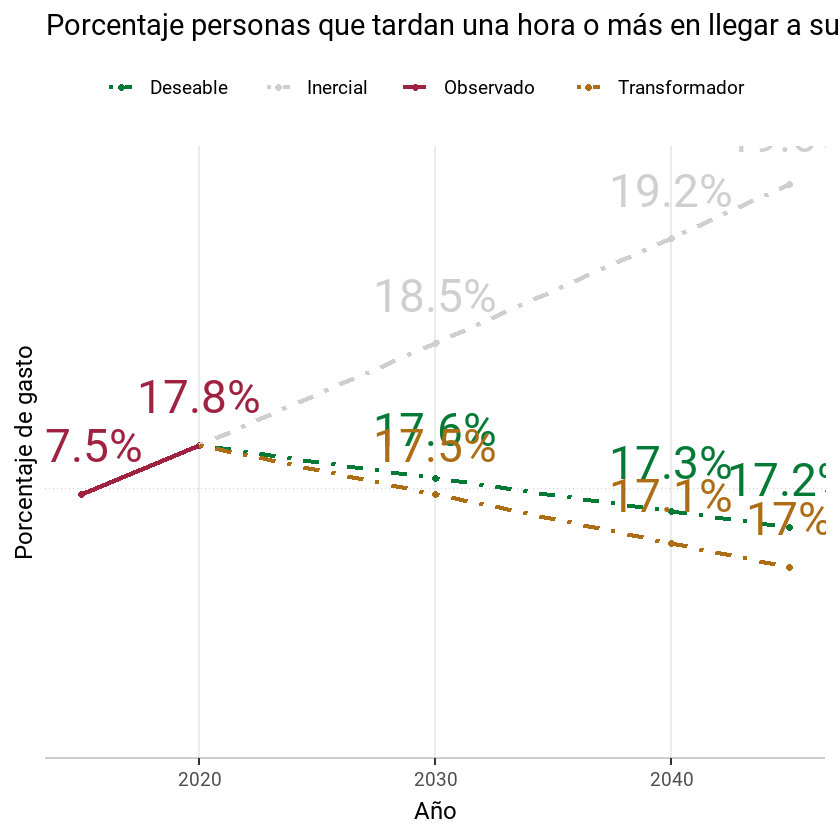

In [92]:
# Gráfico con etiquetas y eje Y personalizado
ggplot(tot_tie_traslado_tendencias, aes(x = año, y = porcentaje, group = tipo, color = tipo, linetype = tipo)) +
  geom_line(linewidth = 1.2) +
  geom_point(size = 1.5) +
  geom_line(data = lineas, aes(x = año, y = porcentaje, group = tipo), linewidth = 1.2) +
  geom_text(aes(label = paste0(round(porcentaje, 1), "%")),
            vjust = -1, size = 12, family = "Roboto", show.legend = FALSE) +
  scale_color_manual(values = paleta_colores) +
  scale_linetype_manual(values = linetypes) +
  scale_y_continuous(breaks = seq(0, max(tot_tie_traslado_tendencias$porcentaje, na.rm = TRUE) + 5, by = 5),
                     labels = function(x) paste0(x, "%"),
                     expand = expansion(mult = c(0.5, 0.1))) +
  labs(title = "Porcentaje personas que tardan una hora o más en llegar a sus centros de estudio o trabajo",
       x = "Año",
       y = "Porcentaje de gasto",
       color = "",
       linetype = "") +
  theme_bw(base_size = 18, base_family = "Roboto") +
  theme( panel.grid.minor.y = element_line(color = "gray80", linetype = "dotted"),
         panel.grid.minor.x = element_blank(),
         panel.grid.major.y = element_blank(),
         panel.border = element_blank(),
         axis.line = element_line(color = "gray80"),
         legend.position = "top",
         plot.caption = element_text(hjust = 0))

ggsave("tot_tie_traslado_tendencias.png", width = 7, height = 5, dpi = 300)


**Porcentaje de población residente de la zona metropolitana con tiempos de traslado a la escuela o trabajo de más de una hora**